# Differential Expression Analysis

The differential expression analysis aims at identifying the genes whose expression levels change between two sample groups. For the differential expression (DE) analysis, we use R package Limma as part of a customised expression pipeline.

At this point, expression and clinical datasets are expected to be clean/preprocessed, containing the same samples and in the same order and ready to use in limma. Do a previous preprocessing if needed.

### Read clinical and expression datasets. GSE15222

In [1]:
datasets=load("/mnt/data/GWES/Microarray/output/GSE15222/objects.RData")
datasets

[1] "expr.log.complete" "clinicalset"

In [2]:
dim(clinicalset)
head(clinicalset)

[1] 336   5

,sex,age,diagnosis,APOEgeno,APOEgroup
,<chr>,<dbl>,<chr>,<int>,<chr>
GSM388327,Female,85,Case,34,Group4
GSM388385,Male,77,Case,34,Group4
GSM388383,Female,90,Case,44,Group4
GSM388302,Male,73,Case,33,Group3
GSM388303,Female,89,Case,44,Group4
GSM388285,Male,86,Case,33,Group3


In [3]:
dim(expr.log.complete)
head(expr.log.complete,n=3L)

[1] 9592  363

,GSM225652,GSM225662,GSM225664,GSM225665,GSM225666,GSM225667,GSM225668,GSM225669,GSM225670,GSM225671,...,GSM388388,GSM388389,GSM388390,GSM388391,GSM388392,GSM388393,GSM388394,GSM388395,GSM388396,GSM388397
GI_10047091-S,12.468587,12.367136,12.931349,11.936586,12.349515,12.343600,12.419823,12.394077,12.374868,12.443017,...,10.949267,11.462465,11.847216,11.361139,8.971136,11.851911,11.358655,11.891294,11.821033,11.625528
GI_10047093-S,7.081468,5.795233,6.246219,6.624542,6.738895,6.640043,7.053141,6.577844,6.751791,6.971065,...,6.477515,6.945243,7.193346,6.512597,5.958902,6.968007,6.916382,7.561493,7.716903,7.725393
GI_10047103-S,9.756334,9.673358,9.813577,10.099799,9.729754,9.819325,9.883315,10.398109,9.862523,10.392574,...,10.829192,10.351871,10.271808,9.808778,10.076091,10.106496,10.000358,10.270667,10.529364,10.520075


**Note: It is very important that clinical and expression datasets have the same samples and maintain the same order. Check for this if working with the two dataset separated, or merge them and work with the merged dataframe.** rownames(clinicalset) or sample name/ID column must be in the same order as colnames(expressionset)

***or use ReadAffy in the previous step and start this tutorial with a single dataset.**

In [4]:
# keep the expression values for those samples in the clinical dataset
expression=expr.log.complete[, rownames(clinicalset)]
dim(expression)

[1] 9592  336

In [5]:
table(colnames(expression) == rownames(clinicalset))


TRUE 
 336 

**Suggested function to keep the same samples in both datasets and in the same order.** It is very useful for heatmaps to create rownames in the expressionset as a combination of conditions from the clinicalset.

In [6]:
# Keep the same samples in both datasets and in the same order
# 1st param: clinical dataframe
# 2nd param: expression dataframe
# returns a list containing the new clinicalset as first element and new expression set as the second element
# optional: create rownames in expressionset as a combination of conditions from clinicalset. Very useful for heatmaps in DE
keepCommonSamplesDF_function<-function(clinicalset,expression.df){  
    merged.df=merge(t(expression.df),clinicalset,by= "row.names")
    # optional - customise
    rownames(merged.df)<-paste(merged.df$Row.names,merged.df$Status,merged.df$APOEgroup,sep="_")
    ncols<-ncol(merged.df)-ncol(clinicalset) # remove columns from clinical data, bear in mind the clinical.match column
    new.expr<-t(merged.df[, 2:ncols] ) # 1st column is Row.names that merge command creates
    from=ncols+1
    to=dim(merged.df)[2]
    new.clinicalset<-merged.df[, from:to]
    return(list(new.clinicalset,new.expr))
}

In [7]:
# call keepCommonSamplesDF function to get clinical and expression sets containing matching samples
sets=keepCommonSamplesDF_function(clinicalset,expr.log.complete) 
clinicalset.common=sets[[1]]
dim(clinicalset.common)
expr.common=sets[[2]]
dim(expr.common)

[1] 336   5

[1] 9592  336

Check that the datasets are correct and keepCommonSamplesDF function fits your needs.

In [8]:
head(clinicalset.common,n=3)
head(expr.common,n=3)

,sex,age,diagnosis,APOEgeno,APOEgroup
,<chr>,<dbl>,<chr>,<int>,<chr>
GSM225652__Group3,Male,85,Control,33,Group3
GSM225662__Group3,Male,85,Control,33,Group3
GSM225664__Group3,Male,79,Control,33,Group3


,GSM225652__Group3,GSM225662__Group3,GSM225664__Group3,GSM225665__Group3,GSM225666__Group3,GSM225667__Group3,GSM225668__Group3,GSM225670__Group4,GSM225671__Group3,GSM225672__Group3,...,GSM388388__Group4,GSM388389__Group3,GSM388390__Group2,GSM388391__Group4,GSM388392__Group3,GSM388393__Group4,GSM388394__Group4,GSM388395__Group4,GSM388396__Group4,GSM388397__Group4
GI_10047091-S,12.468587,12.367136,12.931349,11.936586,12.349515,12.343600,12.419823,12.374868,12.443017,11.133454,...,10.949267,11.462465,11.847216,11.361139,8.971136,11.851911,11.358655,11.891294,11.821033,11.625528
GI_10047093-S,7.081468,5.795233,6.246219,6.624542,6.738895,6.640043,7.053141,6.751791,6.971065,5.909498,...,6.477515,6.945243,7.193346,6.512597,5.958902,6.968007,6.916382,7.561493,7.716903,7.725393
GI_10047103-S,9.756334,9.673358,9.813577,10.099799,9.729754,9.819325,9.883315,9.862523,10.392574,10.088680,...,10.829192,10.351871,10.271808,9.808778,10.076091,10.106496,10.000358,10.270667,10.529364,10.520075


### Differential Expression with Limma

Limma is  a  package  for  the  analysis  of  gene  expression  data  arising  from  microarray  or  RNA-seq technologies

In [9]:
# Import differential expression functions to use the customised anotation function
source("scripts/diffExpressionPipeline.R")

#### prepare limma sets with covariates

In [10]:
model.matrix=model.matrix(~0+diagnosis+age+sex,data = clinicalset.common)
colnames(model.matrix)=c("case","control","age","sexMale")
head(model.matrix)

,case,control,age,sexMale
GSM225652__Group3,0,1,85,1
GSM225662__Group3,0,1,85,1
GSM225664__Group3,0,1,79,1
GSM225665__Group3,0,1,85,0
GSM225666__Group3,0,1,73,0
GSM225667__Group3,0,1,81,1


In [11]:
#design.matrix <- sapply(design_matrix, as.numeric)
contrast.matrix.cov <- makeContrasts(case - control, levels = model.matrix)
set.seed(1)
head(contrast.matrix.cov)

,case - control
case,1
control,-1
age,0
sexMale,0


In [12]:
# This code fits the linear model, smooths the standard errors and displays the top 10 genes for case versus control comparison.
fit.cov <- lmFit(expr.common, model.matrix)
fit.cov <- contrasts.fit(fit.cov, contrast.matrix.cov)
fit.cov <- eBayes(fit.cov)
    
toplist.cov=topTable(fit.cov,sort.by="P",confint=TRUE)
toplist.cov

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GI_23312375-A,-1.1525001,-1.3260708,-0.9789294,6.340362,-13.06101,8.010067e-32,7.683257e-28,61.40136
GI_4585642-S,0.9020393,0.7653437,1.0387349,7.028273,12.98024,1.618642e-31,7.763008e-28,60.71192
GI_34577121-S,0.4974747,0.4131947,0.5817547,8.757105,11.61070,1.932669e-26,6.179388e-23,49.25593
GI_24308166-S,-0.7692022,-0.9030986,-0.6353059,9.843326,-11.30014,2.547848e-25,6.109739e-22,46.72935
GI_37547175-S,0.4318686,0.3558083,0.5079289,8.520153,11.16878,7.515840e-25,1.441839e-21,45.66967
GI_27734844-S,-0.6935349,-0.8166914,-0.5703783,8.107995,-11.07702,1.594728e-24,2.549438e-21,44.93280
GI_44917603-S,0.8832805,0.7241037,1.0424573,6.843249,10.91518,5.969323e-24,8.179678e-21,43.64002
GI_13376557-S,0.8880401,0.7274340,1.0486463,6.699620,10.87633,8.183887e-24,9.191137e-21,43.33099
GI_7706261-S,-0.8013612,-0.9463771,-0.6563453,8.727201,-10.86988,8.623878e-24,9.191137e-21,43.27971


In [13]:
# DE summary
summary(decideTests(fit.cov))

       case - control
Down             2880
NotSig           3586
Up               3126

In [15]:
alltable.cov=topTable(fit.cov,sort.by="P",n=Inf,confint=TRUE)
write.table(alltable.cov,"/mnt/data/GWES/Microarray/output/GSE15222/limma_covariates_results")

#### Annotate limma result

Translate probes to gene symbols using the custom annotate_function.

In [16]:
# call annotate_function to translate probeIDs to gene IDs
alltable.annot<-annotate_function(alltable.cov,platform = "2700")
write.table(alltable.annot,"/mnt/data/GWES/Microarray/output/GSE15222/limma_cov_results_annot")
head(alltable.annot,n=10)


 dim alltable annotated  8477 11 


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,platform,gene_id,organism
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
ZNF264,0.9020393,0.7653437,1.0387349,7.028273,12.98024,1.618642e-31,7.763008e-28,60.71192,GPL2700,9422,Homo sapiens
NFKB1,0.4974747,0.4131947,0.5817547,8.757105,11.61070,1.932669e-26,6.179388e-23,49.25593,GPL2700,4790,Homo sapiens
SVOP,-0.7692022,-0.9030986,-0.6353059,9.843326,-11.30014,2.547848e-25,6.109739e-22,46.72935,GPL2700,55530,Homo sapiens
DSTYK,0.4318686,0.3558083,0.5079289,8.520153,11.16878,7.515840e-25,1.441839e-21,45.66967,GPL2700,25778,Homo sapiens
ZDHHC23,-0.6935349,-0.8166914,-0.5703783,8.107995,-11.07702,1.594728e-24,2.549438e-21,44.93280,GPL2700,254887,Homo sapiens
SRGAP1,0.8832805,0.7241037,1.0424573,6.843249,10.91518,5.969323e-24,8.179678e-21,43.64002,GPL2700,57522,Homo sapiens
ATP6V1H,-0.8013612,-0.9463771,-0.6563453,8.727201,-10.86988,8.623878e-24,9.191137e-21,43.27971,GPL2700,51606,Homo sapiens
POLDIP3,0.3570440,0.2918412,0.4222467,8.021717,10.77129,1.915726e-23,1.837565e-20,42.49807,GPL2700,84271,Homo sapiens
FAM63A,0.7782813,0.6334835,0.9230790,9.302904,10.57272,9.460792e-23,8.249811e-20,40.93425,GPL2700,55793,Homo sapiens


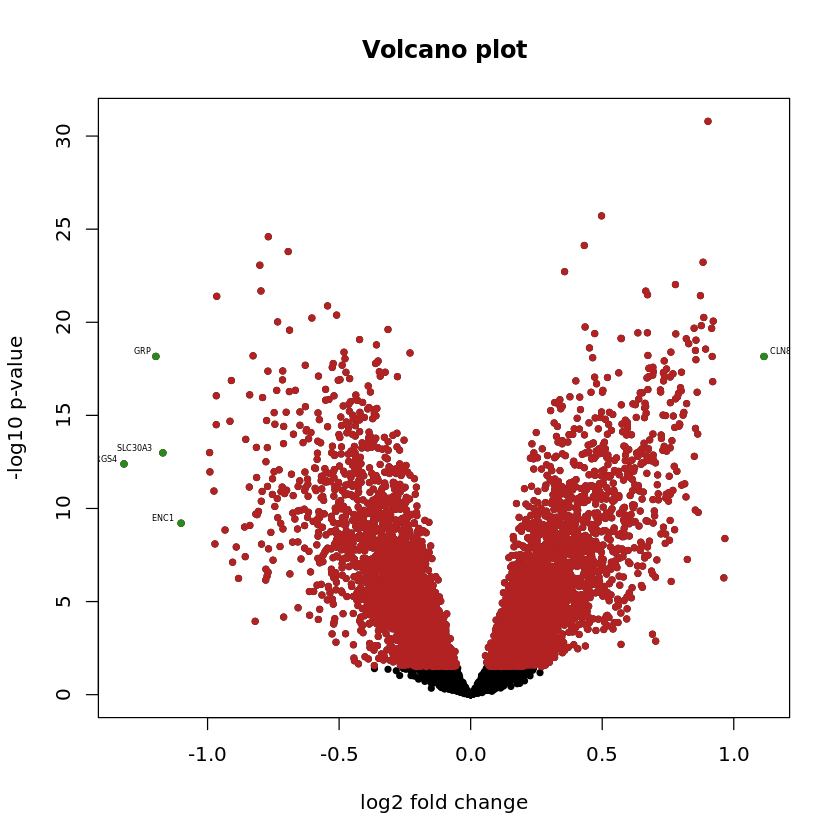

In [19]:
# volcano plot
with(alltable.annot, plot(logFC, -log10(P.Value), pch=20, main="Volcano plot", ylab="-log10 p-value", xlab="log2 fold change"))

# Add colored points: red if padj<0.05, orange of log2FC>1, green if both)
with(subset(alltable.annot, adj.P.Val<.05 ), points(logFC, -log10(P.Value), pch=20, col="firebrick"))
with(subset(alltable.annot, abs(logFC)>1), points(logFC, -log10(P.Value), pch=20, col="darkorange4"))
set<-subset(alltable.annot, adj.P.Val<.05 & abs(logFC)>1)
with(set, points(logFC, -log10(P.Value), pch=20, col="forestgreen"))

# Label points with the textxy function from the calibrate plot
suppressPackageStartupMessages(library(calibrate))
with(set, textxy(logFC, -log10(P.Value), labs=rownames(set), cex=.4))
# if I use as labels rownames(alltable.annot) it is ilegible

A **volcano plot** is a type of scatterplot that shows statistical significance (P value) versus magnitude of change (fold change). It enables quick visual identification of genes with large fold changes that are also statistically significant. These may be the most biologically significant genes. In a volcano plot, the most upregulated genes are towards the right, the most downregulated genes are towards the left, and the most statistically significant genes are towards the top.


**Heatmap**

In [20]:
heatmapset<-expr.common[rownames(alltable.cov[1:50 ,]) ,] #top 50 DE probes
head(heatmapset)

,GSM225652__Group3,GSM225662__Group3,GSM225664__Group3,GSM225665__Group3,GSM225666__Group3,GSM225667__Group3,GSM225668__Group3,GSM225670__Group4,GSM225671__Group3,GSM225672__Group3,...,GSM388388__Group4,GSM388389__Group3,GSM388390__Group2,GSM388391__Group4,GSM388392__Group3,GSM388393__Group4,GSM388394__Group4,GSM388395__Group4,GSM388396__Group4,GSM388397__Group4
GI_23312375-A,6.611988,5.659664,7.971878,6.903179,7.492881,7.276798,6.757963,6.282999,7.119278,5.264021,...,4.819886,4.955807,4.842707,5.805315,5.664338,5.551775,5.812573,6.172799,4.267067,4.441497
GI_4585642-S,6.315483,6.853518,6.217515,7.067976,6.476303,6.349153,6.386436,7.464545,6.637519,6.895331,...,6.657535,8.188358,8.572398,6.424413,7.297561,7.920173,7.903589,8.202572,8.709441,8.454577
GI_34577121-S,8.378822,8.621877,8.336333,8.941759,8.149117,8.098299,8.271234,8.470069,8.289097,9.040073,...,8.778291,9.560877,9.367785,8.922579,9.618416,9.052820,8.970232,8.566525,9.901210,9.484614
GI_24308166-S,9.915939,9.337659,11.055133,9.918557,10.522946,10.730545,10.334266,10.135984,10.538009,9.238586,...,9.534593,9.047545,9.196634,9.586268,7.928463,9.600713,8.883400,9.669283,8.929177,8.965817
GI_37547175-S,8.277881,8.138547,8.308958,8.328487,8.612823,8.389270,8.446931,8.572808,8.285541,8.006519,...,8.398088,9.292573,8.970513,8.628720,9.152614,9.272778,8.846594,9.300726,9.191979,9.123314
GI_27734844-S,8.707477,8.198817,8.684864,8.751515,8.519065,8.516139,8.662714,8.492824,8.615176,7.940739,...,7.043196,7.708043,6.661384,7.086083,6.775205,7.559942,7.860299,7.759689,6.987998,7.431201


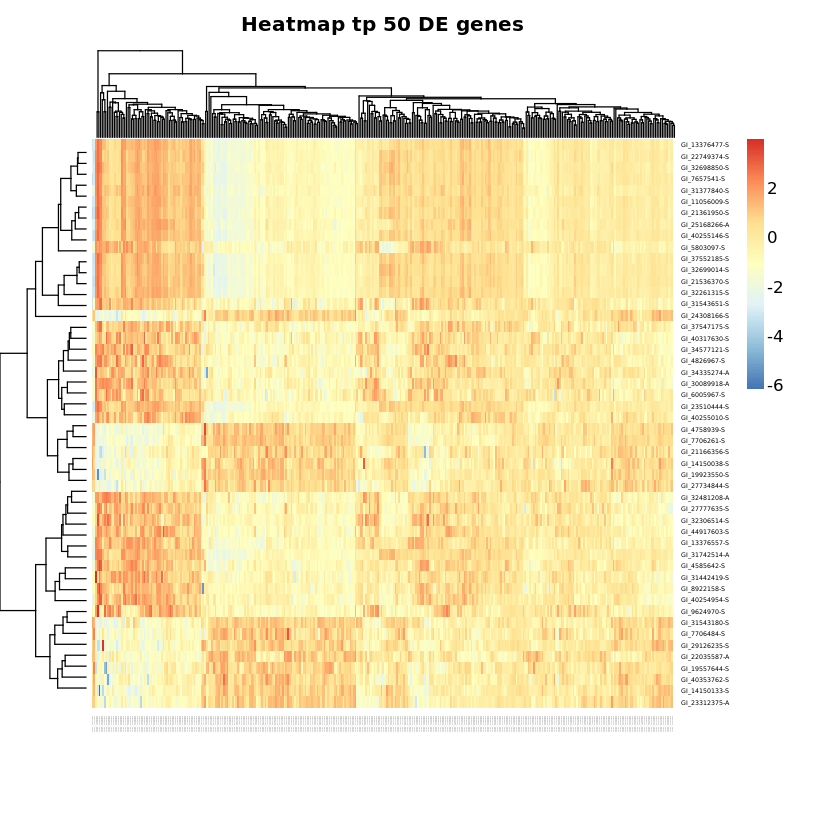

In [23]:
suppressPackageStartupMessages(library(NMF))
aheatmap(as.matrix(heatmapset),Rowv = TRUE , Colv = TRUE ,distfun = "euclidean", hclustfun = "average",scale = "row",main="Heatmap tp 50 DE genes")


In heatmaps the data is displayed in a grid where each row represents a gene and each column represents a sample. The colour and intensity of the boxes is used to represent changes (not absolute values) of gene expression. 